In [147]:
import os
import numpy as np
import pandas as pd

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

In [148]:
class CicIds2017(Dataset):
    BASE_PATH = "C:\VScode Projects\FIIT_MASTERS\DP\datasets\CIC-IDS-2017"
    MAPPING_FILE = "\cicids2017_img.csv"
    index: int
    batch_size: int
    classes_count: int
    classes_list: list
    
    def __init__(self, shuffle: bool = False):        
        self.mapping = pd.read_csv(self.BASE_PATH+self.MAPPING_FILE)
        self.mapping = pd.get_dummies(self.mapping, columns=['label'])
        
        if shuffle:
            self.mapping = self.mapping.sample(frac=1) # shuffle
        
        self.classes_list = [label.split("_")[1] for label in self.mapping.columns[1:]]
        
        self.mapping = self.mapping.to_numpy()
        
        self.classes_count = len(self.mapping[0]) - 1
        
        self.transform = transforms.Compose([transforms.ToTensor()]) 
        
    def __len__(self):
        return len(self.mapping)
    
    def __getitem__(self, idx):
        img_name = self.mapping[idx, 0]
        img_path = os.path.join(self.BASE_PATH + "\image", img_name)
        img = read_image(img_path)
        
        label = [1 if label_class is True else 0 for label_class in self.mapping[idx, 1:]]
        label = np.array(label)
        
        return img, label
    
    def translate_encoded_label(self, encoded_label):
        return self.classes_list[list(encoded_label).index(1)]

In [149]:
dataset = CicIds2017()
dataset.classes_count

15

In [150]:
dataset.classes_list

['BENIGN',
 'Bot',
 'DDoS',
 'DoS GoldenEye',
 'DoS Hulk',
 'DoS Slowhttptest',
 'DoS slowloris',
 'FTP-Patator',
 'Heartbleed',
 'Infiltration',
 'PortScan',
 'SSH-Patator',
 'Web Attack – Brute Force',
 'Web Attack – Sql Injection',
 'Web Attack – XSS']

In [151]:
img, label = dataset.__getitem__(idx=0)
img.shape

torch.Size([3, 32, 64])

In [152]:
label

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [153]:
label.shape

(15,)

In [154]:
dataset.translate_encoded_label(label)

'BENIGN'

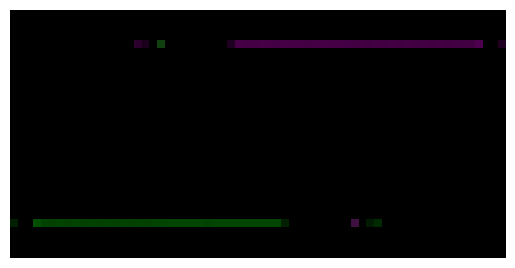

In [155]:
import matplotlib.pyplot as plt
plt.imshow(img.numpy().transpose((1, 2, 0)))
plt.axis('off')  # Remove axes
plt.show()

In [156]:
loader = DataLoader(dataset, batch_size=64)
train_features, train_labels = next(iter(loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 3, 32, 64])
Labels batch shape: torch.Size([64, 15])
